# HW-2: 1| Cross-Validation

## 1(a) OLS

For your proposed model, compute the OLS solution2 with 6-fold cross-validation over the data in
cleaned_automobile_train_dataset.pt3. Let wˆ(i) OLS denote the solution for the ith split, for i = 1...6.For each split i, compute the mean square error (MSE) of wˆ(i)
OLS, both for the train subset (130),and for the validation subset (26). Also, compute the average MSE, for both training subset and
validation subset, averaged over 6 splits. Print your results.

**Answer**:

Loaded dataset successfully!
Features shape: torch.Size([156, 13]), Target shape: torch.Size([156, 1])
Feature Names: ['wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-size', 'bore', 'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg'], Target Name: price
Loaded dataset successfully!
Features shape: torch.Size([39, 13]), Target shape: torch.Size([39, 1])
Feature Names: ['wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-size', 'bore', 'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg'], Target Name: price
----| Dropping highly correlated features

High correlation detected: wheel-base and length (Corr = 0.87)
High correlation detected: length and width (Corr = 0.85)
High correlation detected: length and curb-weight (Corr = 0.87)
High correlation detected: city-mpg and highway-mpg (Corr = 0.97)
Dropped features: ['curb-weight', 'highway-mpg', 'length', 'width']
Remaining features: ['wheel-base

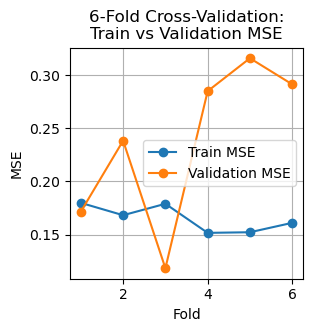

In [119]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")


# Set random seed for reproducibility
SEED = 2000
np.random.seed(SEED)
torch.manual_seed(SEED)

# Data loading function
def load_dataset(file_path):
    """
    Load the saved PyTorch .pt dataset from the given file path.
    """
    dataset = torch.load(file_path)
    print("Loaded dataset successfully!")
    print(f"Features shape: {dataset['features'].shape}, Target shape: {dataset['target'].shape}")
    print(f"Feature Names: {dataset['feature_names']}, Target Name: {dataset['target_name']}")
    return dataset["features"], dataset["target"], dataset["feature_names"], dataset["target_name"]

# Load train dataset
train_file_path = "cleaned_automobile_train_dataset.pt"
X_train, y_train, feature_names, y_train_name = load_dataset(train_file_path)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

rid = torch.randperm(X_train.shape[0])
X_train = X_train[rid,:]
y_train = y_train[rid,:]

# Load test dataset
test_file_path = "cleaned_automobile_test_dataset.pt"
X_test, y_test, feature_names, y_test_name = load_dataset(test_file_path)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

print('----| Dropping highly correlated features\n')
# Function to drop highly correlated features
def drop_highly_correlated_features(X_train, X_test, feature_names, threshold=0.85):
    df_train = pd.DataFrame(X_train.numpy(), columns=feature_names)
    corr_matrix = df_train.corr().abs()
    
    to_drop = set()
    for i in range(len(feature_names)):
        for j in range(i + 1, len(feature_names)):
            if corr_matrix.iloc[i, j] > threshold:
                feature1 = feature_names[i]
                feature2 = feature_names[j]
                print(f"High correlation detected: {feature1} and {feature2} (Corr = {corr_matrix.iloc[i, j]:.2f})")
                to_drop.add(feature2)  # Arbitrarily drop the second feature
    
    filtered_feature_names = [f for f in feature_names if f not in to_drop]
    
    X_train_filtered = df_train.drop(columns=to_drop).values
    X_test_filtered = pd.DataFrame(X_test.numpy(), columns=feature_names).drop(columns=to_drop).values
    
    print(f"Dropped features: {sorted(to_drop)}")
    print(f"Remaining features: {filtered_feature_names}")
    print(f"New training feature shape: {X_train_filtered.shape}")
    print(f"New testing feature shape: {X_test_filtered.shape}")
    
    return torch.tensor(X_train_filtered, dtype=torch.float32), torch.tensor(X_test_filtered, dtype=torch.float32), filtered_feature_names

# Apply function to drop highly correlated features
X_train, X_test, feature_names = drop_highly_correlated_features(X_train, X_test, feature_names)
# Add bias term (column of ones) to X_train and X_test
X_train = torch.hstack([X_train, torch.ones((X_train.shape[0], 1))])
X_test  = torch.hstack([X_test, torch.ones((X_test.shape[0], 1))])

print('\n')
print('6-Fold Cross-Validation for OLS\n')
# 6-Fold Cross-Validation for OLS
kf = KFold(n_splits=6, shuffle=True, random_state=SEED)
train_mse_list = []
val_mse_list   = []


for train_idx, val_idx in kf.split(X_train):
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]
    
    # Compute OLS weights
    XTX = X_tr.T @ X_tr
    XTY = X_tr.T @ y_tr
    OLS_W = torch.linalg.solve(XTX + 1e-10 * torch.norm(XTX) * torch.eye(XTX.shape[0]), XTY)
    
    # Train Predictions
    OLS_Y_pred_train = torch.einsum('ki,i->k', (X_tr, OLS_W.squeeze()))[:, None]
    ss_res_train = ((y_tr - OLS_Y_pred_train) ** 2).sum().item()
    ss_tot_train = ((y_tr - y_tr.mean()) ** 2).sum().item()
    r2_train = 1 - (ss_res_train / ss_tot_train)
    mse_train = 1 - r2_train
    train_mse_list.append(mse_train)
    
    # Validation Predictions
    OLS_Y_pred_val = torch.einsum('ki,i->k', (X_val, OLS_W.squeeze()))[:, None]
    ss_res_val = ((y_val - OLS_Y_pred_val) ** 2).sum().item()
    ss_tot_val = ((y_val - y_val.mean()) ** 2).sum().item()
    r2_val = 1 - (ss_res_val / ss_tot_val)
    mse_val = 1 - r2_val
    val_mse_list.append(mse_val)
    
    print(f"Fold MSE - Train: {mse_train:.4f}, Validation: {mse_val:.4f}")

# Compute average MSE over 6 splits
avg_train_mse = np.mean(train_mse_list)
avg_val_mse   = np.mean(val_mse_list)
print(f"Average MSE - Train: {avg_train_mse:.4f}, Validation: {avg_val_mse:.4f}")

# Plot Train vs Validation MSE
plt.figure(figsize=(3, 3))
plt.plot(range(1, 7), train_mse_list, marker='o', label='Train MSE', linestyle='-')
plt.plot(range(1, 7), val_mse_list, marker='o', label='Validation MSE', linestyle='-')
plt.xlabel('Fold')
plt.ylabel('MSE')
plt.title('6-Fold Cross-Validation:\nTrain vs Validation MSE')
plt.legend()
plt.grid()
plt.show()

## 1(b) Ridge Regression & Lamda Estimation

**(Ridge Regression)** The λ-Ridge-Regression is
wˆridge,λ = argmin
w
1
n
nΣ
j=1
(yj −w⊤φ(xj))2+λ∥w∥22
Pick 10 values of λ on a log scale (e.g. λ ∈ {2,1,0.5,0.25...}. Pick your λ’s such that for the largest
λ, 0.1∥wˆlasso,0∥2 < ∥wˆridge,λ ∥2 < 0.5∥wˆridge,0∥2 (where wˆridge,λ is computed over the entire training
set).
Plot ∥wˆridge,λ ∥2 against λ (use log scale for λ)

**Answer**:

Lambda values do not satisfy the condition!


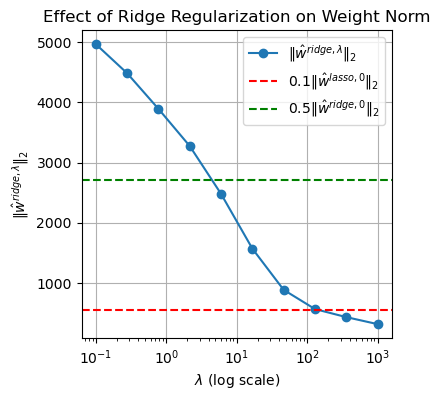

Estimated Lambda Values: [1.00000000e-01 2.78255940e-01 7.74263683e-01 2.15443469e+00
 5.99484250e+00 1.66810054e+01 4.64158883e+01 1.29154967e+02
 3.59381366e+02 1.00000000e+03]


In [126]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso

# Function for Ridge Regression (Closed-Form Solution)
def ridge_regression(X, y, lambda_):
    I = torch.eye(X.shape[1])
    XTX = X.T @ X + lambda_ * I
    XTY = X.T @ y
    return torch.linalg.solve(XTX + (1e-10) * I * XTX.norm(), XTY)

# Function for LASSO Regression (Soft-Thresholding)
def lasso_regression(X, y, lambda_, num_iters=100):
    #W_lasso = torch.linalg.solve(X.T @ X, X.T @ y)  # Initial OLS estimate
    #for _ in range(num_iters):
    #    W_lasso = torch.sign(W_lasso) * torch.clamp(torch.abs(W_lasso) - lambda_, min=0)  # Soft-thresholding
    lasso = Lasso(alpha=0.00000001, fit_intercept=False, max_iter=1000000,tol=1e-8)
    lasso.fit(X.numpy(), y.numpy())
    W_lasso = torch.tensor(lasso.coef_)
    return W_lasso

def check_lambda_and_plot(X_train, Y_train):
    # Define lambda values on a log scale
    lambda_values = np.logspace(-1, 3, 10)

    # Convert to Torch tensors if not already
    X_train = torch.tensor(X_train, dtype=torch.float32)
    Y_train = torch.tensor(Y_train, dtype=torch.float32).view(-1, 1)

    # Train Lasso for lambda ≈ 0 (approximate OLS)
    # lasso_0 is same as ridge_0, so just use ridge for stability reasons
    w_lasso_0 = ridge_regression(X_train, Y_train, lambda_=0)
    w_lasso_0_norm = np.linalg.norm(w_lasso_0.numpy(), 2)

    # Train Ridge for lambda = 0 (OLS solution)
    w_ridge_0 = ridge_regression(X_train, Y_train, lambda_=0)
    w_ridge_0_norm = np.linalg.norm(w_ridge_0.numpy(), 2)

    # Compute Ridge regression norms for different lambda values
    ridge_norms = []
    for lam in lambda_values:
        w_ridge_lambda = ridge_regression(X_train, Y_train, lambda_=lam)
        ridge_norms.append(np.linalg.norm(w_ridge_lambda.numpy(), 2))

    # Check if the last lambda satisfies the condition
    w_ridge_lambda_norm = ridge_norms[-1]
    if 0.1 * w_lasso_0_norm < w_ridge_lambda_norm < 0.5 * w_ridge_0_norm:
        print("Lambda values satisfy the condition!")
    else:
        print("Lambda values do not satisfy the condition!")

    # Plot the results
    plt.figure(figsize=(4, 4))
    plt.plot(lambda_values, ridge_norms, marker='o', linestyle='-', label=r'$\|\hat{w}^{ridge,\lambda}\|_2$')
    plt.axhline(y=0.1 * w_lasso_0_norm, color='r', linestyle='--', label=r'$0.1\|\hat{w}^{lasso,0}\|_2$')
    plt.axhline(y=0.5 * w_ridge_0_norm, color='g', linestyle='--', label=r'$0.5\|\hat{w}^{ridge,0}\|_2$')
    plt.xscale('log')  # Use log scale for lambda
    plt.xlabel(r'$\lambda$ (log scale)')
    plt.ylabel(r'$\|\hat{w}^{ridge,\lambda}\|_2$')
    plt.title('Effect of Ridge Regularization on Weight Norm')
    plt.legend()
    plt.grid(True)
    plt.show()

    return lambda_values

# Run the function and store lambda values
lambda_values = check_lambda_and_plot(X_train.numpy(), y_train.numpy())
print("Estimated Lambda Values:", lambda_values)


## 1(c) Ridge 6-fold cross-validation

For each λ from (b), perform 6-fold cross-validation, as you did in (a), and compute:
1. cross-validation train MSE of wˆridge,λ
2. cross-validation validation MSE of wˆridge,λ
Plot the two MSE losses above against λ. (use log scale for x-axis.)

**Answer**:



6-Fold Cross-Validation for Ridge

Lambda: 0.1000 | Avg Train MSE: 0.1657 | Avg Validation MSE: 0.2367
Lambda: 0.2783 | Avg Train MSE: 0.1661 | Avg Validation MSE: 0.2362
Lambda: 0.7743 | Avg Train MSE: 0.1668 | Avg Validation MSE: 0.2347
Lambda: 2.1544 | Avg Train MSE: 0.1681 | Avg Validation MSE: 0.2317
Lambda: 5.9948 | Avg Train MSE: 0.1713 | Avg Validation MSE: 0.2289
Lambda: 16.6810 | Avg Train MSE: 0.1772 | Avg Validation MSE: 0.2300
Lambda: 46.4159 | Avg Train MSE: 0.1833 | Avg Validation MSE: 0.2337
Lambda: 129.1550 | Avg Train MSE: 0.1876 | Avg Validation MSE: 0.2372
Lambda: 359.3814 | Avg Train MSE: 0.1917 | Avg Validation MSE: 0.2414
Lambda: 1000.0000 | Avg Train MSE: 0.1998 | Avg Validation MSE: 0.2504


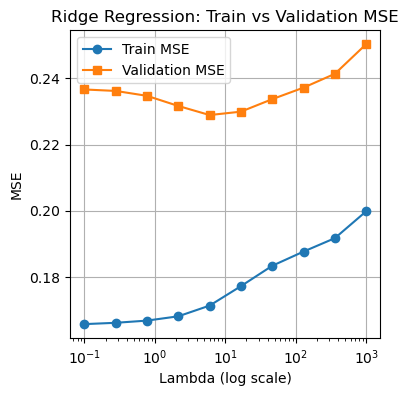

In [127]:
print('\n')
print('6-Fold Cross-Validation for Ridge\n')
kf = KFold(n_splits=6, shuffle=True, random_state=SEED)
train_mse_list = []
val_mse_list   = []

for lambda_ in lambda_values:
    fold_train_mse = []
    fold_val_mse = []
    
    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]
        
        W_ridge = ridge_regression(X_tr, y_tr, lambda_)
        
        # Train Predictions
        Y_pred_train = X_tr @ W_ridge
        ss_res_train = ((y_tr - Y_pred_train) ** 2).sum().item()
        ss_tot_train = ((y_tr - y_tr.mean()) ** 2).sum().item()
        r2_train = 1 - (ss_res_train / ss_tot_train)
        mse_train = 1 - r2_train
        fold_train_mse.append(mse_train)
        
        # Validation Predictions
        Y_pred_val = X_val @ W_ridge
        ss_res_val = ((y_val - Y_pred_val) ** 2).sum().item()
        ss_tot_val = ((y_val - y_val.mean()) ** 2).sum().item()
        r2_val = 1 - (ss_res_val / ss_tot_val)
        mse_val = 1 - r2_val
        fold_val_mse.append(mse_val)
    
    train_mse_list.append(np.mean(fold_train_mse))
    val_mse_list.append(np.mean(fold_val_mse))
    print(f"Lambda: {lambda_:.4f} | Avg Train MSE: {np.mean(fold_train_mse):.4f} | Avg Validation MSE: {np.mean(fold_val_mse):.4f}")


    
    
# Plot Train vs Validation MSE
plt.figure(figsize=(4, 4))
plt.plot(lambda_values, train_mse_list, marker='o', label='Train MSE', linestyle='-')
plt.plot(lambda_values, val_mse_list, marker='s', label='Validation MSE', linestyle='-')
plt.xscale('log')
plt.xlabel('Lambda (log scale)')
plt.ylabel('MSE')
plt.title('Ridge Regression: Train vs Validation MSE')
plt.legend()
plt.grid()
plt.show()



## 1(d) Ridge Regression Test

(Ridge Regression) Identify the best λ∗ from (c) based on validation error. Would your choice
of λ have been different based on train error?
Compute wˆridge,λ∗ using the entire train dataset, and evaluate the MSE loss on the test dataset
(cleaned_automobile_test_dataset.pt). Print both the average-6-fold-validation-MSE
and the test-MSE.

Best Lambda (based on validation MSE): 5.9948


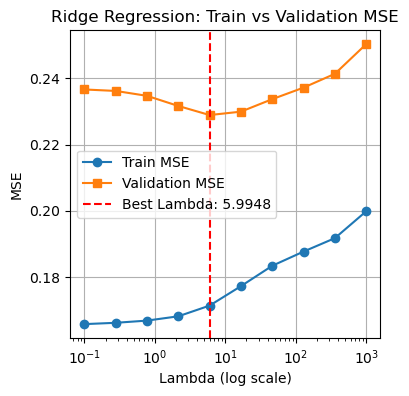

Avg. 6-fold Validation MSE:0.2289, Test MSE: 0.1704, Test R²: 0.8296


In [128]:
# Identify best lambda based on validation error
best_lambda_index = np.argmin(val_mse_list)
best_lambda = lambda_values[best_lambda_index].item()
print(f"Best Lambda (based on validation MSE): {best_lambda:.4f}")

# Compute Ridge Regression using best lambda on full training dataset
W_ridge_best = ridge_regression(X_train, y_train, best_lambda)

# Plot Train vs Validation MSE
plt.figure(figsize=(4, 4))
plt.plot(lambda_values, train_mse_list, marker='o', label='Train MSE', linestyle='-')
plt.plot(lambda_values, val_mse_list, marker='s', label='Validation MSE', linestyle='-')
plt.axvline(best_lambda, color='red', linestyle='--', label=f'Best Lambda: {best_lambda:.4f}')
plt.xscale('log')
plt.xlabel('Lambda (log scale)')
plt.ylabel('MSE')
plt.title('Ridge Regression: Train vs Validation MSE')
plt.legend()
plt.grid()
plt.show()




# Evaluate on test set
Y_pred_test = X_test @ W_ridge_best
ss_res_test = ((y_test - Y_pred_test) ** 2).sum().item()
ss_tot_test = ((y_test - y_test.mean()) ** 2).sum().item()
r2_test = 1 - (ss_res_test / ss_tot_test)
mse_test = 1 - r2_test
print(f"Avg. 6-fold Validation MSE:{val_mse_list[best_lambda_index]:.4f}, Test MSE: {mse_test:.4f}, Test R²: {r2_test:.4f}")

## 1(e) LASSO 

**(LASSO) The λ-LASSO** is
wˆlasso,λ = argmin
w
1
n
nΣ
j=1
(yj −w⊤φ(xj))2+λ∥w∥1


Pick 10 values of λ on a log scale (e.g. λ ∈ {2,1,0.5,0.25...}). Pick your λ’s such that for the
largest λ (and only the largest λ), wˆlasso,λ is all 0 (where wˆlasso,λ is computed over the entire
training set).
Plot ∥wˆlasso,λ ∥1 against λ (use log scale for λ).
Plot the [number of entries of wˆlasso,λ which are exactly 0], against λ (use log scale for λ).

**Answer:**

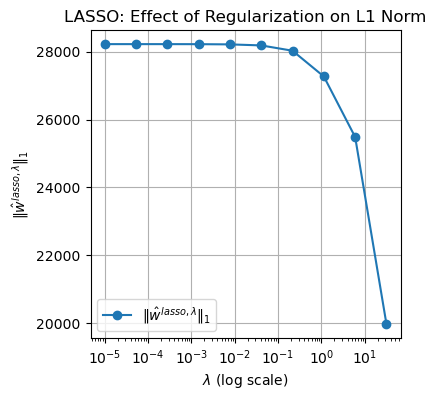

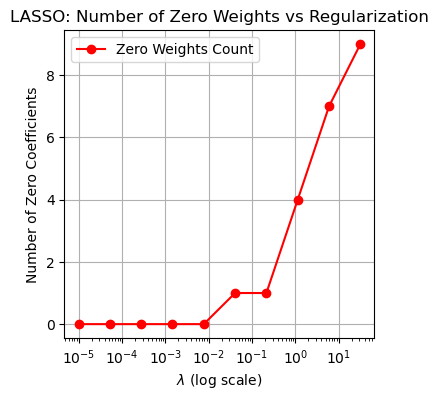

Estimated Lambda Values: [3.16227766e+01 5.99484250e+00 1.13646367e+00 2.15443469e-01
 4.08423865e-02 7.74263683e-03 1.46779927e-03 2.78255940e-04
 5.27499706e-05 1.00000000e-05]


In [135]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Function for LASSO Regression (Soft-Thresholding)
def lasso_regression(X, y, lambda_, num_iters=100):
    W_lasso = torch.linalg.solve(X.T @ X, X.T @ y)  # Initial OLS estimate
    for _ in range(num_iters):
        W_lasso = torch.sign(W_lasso) * torch.clamp(torch.abs(W_lasso) - lambda_, min=0)  # Soft-thresholding
    return W_lasso

# Function to estimate Lambda values and plot results
def estimate_lasso_lambda(X_train, y_train):
    # Convert to Torch tensors (if not already)
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

    # Generate 10 lambda values on a log scale
    lambda_values = np.logspace(1.5, -5, 10)  # From 1 to 0.001

    # Store L1 norms and number of zero coefficients
    l1_norms = []
    zero_counts = []

    for lam in lambda_values:
        # Compute LASSO weights using your function
        w_lasso = lasso_regression(X_train, y_train, lambda_=lam)

        # Compute L1 norm of weights
        l1_norms.append(torch.norm(w_lasso, p=1).item())

        # Count number of zero weights
        zero_counts.append(torch.sum(w_lasso == 0).item())

    # Plot L1 norm vs Lambda
    plt.figure(figsize=(4, 4))
    plt.plot(lambda_values, l1_norms, marker='o', linestyle='-', label=r'$\|\hat{w}^{lasso,\lambda}\|_1$')
    plt.xscale('log')
    plt.xlabel(r'$\lambda$ (log scale)')
    plt.ylabel(r'$\|\hat{w}^{lasso,\lambda}\|_1$')
    plt.title('LASSO: Effect of Regularization on L1 Norm')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Number of Zero Weights vs Lambda
    plt.figure(figsize=(4, 4))
    plt.plot(lambda_values, zero_counts, marker='o', linestyle='-', color='r', label='Zero Weights Count')
    plt.xscale('log')
    plt.xlabel(r'$\lambda$ (log scale)')
    plt.ylabel('Number of Zero Coefficients')
    plt.title('LASSO: Number of Zero Weights vs Regularization')
    plt.legend()
    plt.grid(True)
    plt.show()

    return lambda_values

# Run the function and store lambda values
lambda_values = estimate_lasso_lambda(X_train.numpy(), y_train.numpy())
print("Estimated Lambda Values:", lambda_values)


# 1(f) lasso Cross-Validations

For each λ, perform 6-fold cross-validation, as you did in (a), and compute:
1. cross-validation train MSE of wˆlasso,λ
2. cross-validation validation MSE of wˆlasso,λ
Plot the two MSE losses above against λ. (use log scale for x-axis.)

**Answer:**

Lambda: 31.62 | Avg Train MSE: 24.08 | Avg Validation MSE: 25.36 | Avg Zero Coeffs: 8.666666666666666
Lambda: 5.99 | Avg Train MSE: 44.27 | Avg Validation MSE: 48.16 | Avg Zero Coeffs: 7.0
Lambda: 1.14 | Avg Train MSE: 34.08 | Avg Validation MSE: 38.10 | Avg Zero Coeffs: 3.5
Lambda: 0.22 | Avg Train MSE: 4.50 | Avg Validation MSE: 4.82 | Avg Zero Coeffs: 1.1666666666666667
Lambda: 0.04 | Avg Train MSE: 1.59 | Avg Validation MSE: 1.64 | Avg Zero Coeffs: 1.1666666666666667
Lambda: 0.01 | Avg Train MSE: 0.50 | Avg Validation MSE: 0.56 | Avg Zero Coeffs: 0.16666666666666666
Lambda: 0.00 | Avg Train MSE: 0.17 | Avg Validation MSE: 0.24 | Avg Zero Coeffs: 0.0
Lambda: 0.00 | Avg Train MSE: 0.16 | Avg Validation MSE: 0.23 | Avg Zero Coeffs: 0.0
Lambda: 0.00 | Avg Train MSE: 0.16 | Avg Validation MSE: 0.23 | Avg Zero Coeffs: 0.0
Lambda: 0.00 | Avg Train MSE: 0.16 | Avg Validation MSE: 0.23 | Avg Zero Coeffs: 0.0


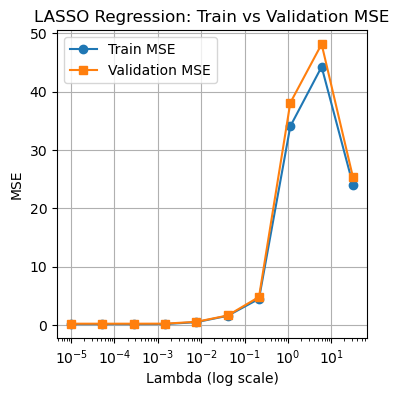

In [136]:

# 6-Fold Cross-Validation for LASSO Regression
train_mse_list = []
val_mse_list = []
num_zero_weights = []

for lambda_ in lambda_values:
    fold_train_mse = []
    fold_val_mse = []
    fold_zero_weights = []
    
    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]
        
        W_lasso = lasso_regression(X_tr, y_tr, lambda_)
        
        # Train Predictions
        Y_pred_train = X_tr @ W_lasso
        ss_res_train = ((y_tr - Y_pred_train) ** 2).sum().item()
        ss_tot_train = ((y_tr - y_tr.mean()) ** 2).sum().item()
        r2_train = 1 - (ss_res_train / ss_tot_train)
        mse_train = 1 - r2_train
        fold_train_mse.append(mse_train)
        
        # Validation Predictions
        Y_pred_val = X_val @ W_lasso
        ss_res_val = ((y_val - Y_pred_val) ** 2).sum().item()
        ss_tot_val = ((y_val - y_val.mean()) ** 2).sum().item()
        r2_val = 1 - (ss_res_val / ss_tot_val)
        mse_val = 1 - r2_val
        fold_val_mse.append(mse_val)
        
        # Count zero weights
        fold_zero_weights.append((W_lasso.abs() < 1e-6).sum().item())  # Check small values near zero
    
    train_mse_list.append(np.mean(fold_train_mse))
    val_mse_list.append(np.mean(fold_val_mse))
    num_zero_weights.append(np.mean(fold_zero_weights))
    print(f"Lambda: {lambda_:.2f} | Avg Train MSE: {np.mean(fold_train_mse):.2f} | Avg Validation MSE: {np.mean(fold_val_mse):.2f} | Avg Zero Coeffs: {np.mean(fold_zero_weights)}")




# Plot Train vs Validation MSE
plt.figure(figsize=(4, 4))
plt.plot(lambda_values, train_mse_list, marker='o', label='Train MSE', linestyle='-')
plt.plot(lambda_values, val_mse_list, marker='s', label='Validation MSE', linestyle='-')
plt.xscale('log')
plt.xlabel('Lambda (log scale)')
plt.ylabel('MSE')
plt.title('LASSO Regression: Train vs Validation MSE')
plt.legend()
plt.grid()
plt.show()


## 1(g)

(LASSO) Identify the best λ∗ from (f) based on validation error. Would your choice of λ have
been different based on train error?
Compute wˆlasso,λ∗ using the entire train dataset, and evaluate the MSE loss on the test dataset
(cleaned_automobile_test_dataset.pt).
Print both the 6-fold-cross-validation-MSE and the test-MSE.
Print the number of 0 entries of wˆlasso,λ∗

**Answer**

Best Lambda (based on validation MSE): 0.0003
Test MSE: 0.1480, Test R²: 0.8520
Number of zero coefficients in W_lasso_best: 0


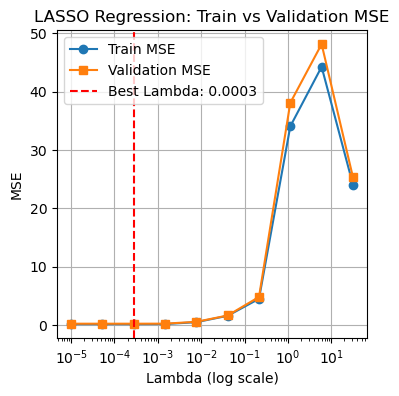

In [137]:
# Identify best lambda based on validation error
best_lambda_index = np.argmin(val_mse_list)
best_lambda = lambda_values[best_lambda_index]
print(f"Best Lambda (based on validation MSE): {best_lambda:.4f}")

# Compute LASSO using best lambda on full training dataset
W_lasso_best = lasso_regression(X_train, y_train, best_lambda)

# Evaluate on test set
Y_pred_test = X_test @ W_lasso_best
ss_res_test = ((y_test - Y_pred_test) ** 2).sum().item()
ss_tot_test = ((y_test - y_test.mean()) ** 2).sum().item()
r2_test = 1 - (ss_res_test / ss_tot_test)
mse_test = 1 - r2_test
print(f"Test MSE: {mse_test:.4f}, Test R²: {r2_test:.4f}")
print(f"Number of zero coefficients in W_lasso_best: {(W_lasso_best.abs() < 1e-6).sum().item()}")  # Check near-zero weights


# Plot Train vs Validation MSE
plt.figure(figsize=(4, 4))
plt.plot(lambda_values, train_mse_list, marker='o', label='Train MSE', linestyle='-')
plt.plot(lambda_values, val_mse_list, marker='s', label='Validation MSE', linestyle='-')
plt.axvline(best_lambda, color='red', linestyle='--', label=f'Best Lambda: {best_lambda:.4f}')
plt.xscale('log')
plt.xlabel('Lambda (log scale)')
plt.ylabel('MSE')
plt.title('LASSO Regression: Train vs Validation MSE')
plt.legend()
plt.grid()
plt.show()